<a href="https://colab.research.google.com/github/yqwang1/Computational_Neuro/blob/main/Neural_network_prediction_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for this exercise the data is too big for github, so we download it and the
# library separately

!pip install gdown
!gdown 1URVviHC1YhzJqF38YEIynmIOSKZrurIH
!wget https://raw.githubusercontent.com/kdharris101/NeuralCodingClass/refs/heads/main/neurocode.py

Downloading...
From (original): https://drive.google.com/uc?id=1URVviHC1YhzJqF38YEIynmIOSKZrurIH
From (redirected): https://drive.google.com/uc?id=1URVviHC1YhzJqF38YEIynmIOSKZrurIH&confirm=t&uuid=86b21b2a-7dfc-4b25-93a1-77427ed89f82
To: /content/cadena_ploscb_data.pkl
100% 608M/608M [00:10<00:00, 55.3MB/s]
--2025-01-26 14:59:32--  https://raw.githubusercontent.com/kdharris101/NeuralCodingClass/refs/heads/main/neurocode.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7870 (7.7K) [text/plain]
Saving to: ‘neurocode.py’

neurocode.py        100%[===================>]   7.69K  --.-KB/s    in 0s      

2025-01-26 14:59:32 (69.6 MB/s) - ‘neurocode.py’ saved [7870/7870]



In [ ]:
# import pytorch neural network library as well as some others

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import types
import pickle


import scipy.stats as sps

from sklearn import linear_model

import neurocode as nc


In [ ]:
# load the data and see what's in it
# this time the data is in a "pickle file", which stores python objects

with open('cadena_ploscb_data.pkl', 'rb') as g:
    loaded_data = pickle.load(g)

for k in loaded_data.keys():
  print(f'loaded_data.{k:<20}: size {loaded_data[k].shape}\t dtype {loaded_data[k].dtype}')

loaded_data.repetitions         : size (166,)	 dtype int64
loaded_data.subject_id          : size (166,)	 dtype int64
loaded_data.session_id          : size (166,)	 dtype int64
loaded_data.image_ids           : size (7250, 1)	 dtype uint16
loaded_data.unit_id             : size (166,)	 dtype int64
loaded_data.image_types         : size (7250, 1)	 dtype object
loaded_data.images              : size (7250, 140, 140)	 dtype float32
loaded_data.responses           : size (4, 7250, 166)	 dtype float64
loaded_data.image_numbers       : size (7250, 1)	 dtype uint16


(-0.5, 39.5, 39.5, -0.5)

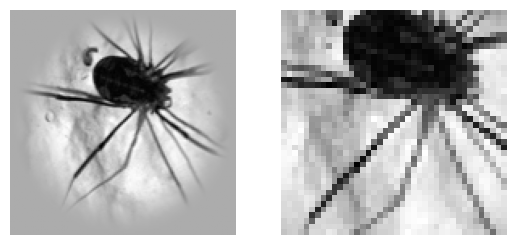

In [ ]:
# Cadena et al cropped and downsampled the images before feeding them into
# the ANN.  Let's do this and look at some of them
#
# we also convert to torch.tensor because that's what pytorch needs

images = torch.tensor(loaded_data['images'][:,None,30:-30:2,30:-30:2], dtype=torch.float32).repeat(1,3,1,1)

ExampleImage = 30
plt.subplot(1,2,1)
plt.imshow(loaded_data['images'][ExampleImage], cmap='gray')
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(images[ExampleImage,1].detach(), cmap='gray')
plt.axis(False)


EXERCISE 1: look at some of the other images in the dataset by changing ExampleImage

In [ ]:
# now we load the vgg19 network and run the data through it.

# UNFORTUNATELY COLAB DOESN'T HAVE ENOUGH MEMORY TO DO THIS!!
# so instead of running the code we will just load the results

outLayer = 16

if 0: # this is what we would run if enough memory
  # load network weights
  vgg = torchvision.models.vgg19_bn(weights='IMAGENET1K_V1')

  # run the images through the vgg network. Outs is a list of tensors, one for each layer, size (nImages,nChannels,H,W)
  # z-score the final layer outputs when done
  outLayer = 16

  features = images.clone()
  for i,f in enumerate(vgg.features[:outLayer+1]):
    features = f(features)
    print('run layer %d/%d'%(i, len(vgg.features)))

  features = features.detach().cpu().numpy()
  features = (features-features.mean(0,keepdims=1))/(features.std(0,keepdims=1) + .01)

else: # just load the output already run
  !gdown 1x7rKDwq2wtZvEnp_dD2X4p84xx1D8gZk

  with open('vgg19_conv3_1_features.pkl', 'rb') as g:
      features = pickle.load(g)

Downloading...
From (original): https://drive.google.com/uc?id=1x7rKDwq2wtZvEnp_dD2X4p84xx1D8gZk
From (redirected): https://drive.google.com/uc?id=1x7rKDwq2wtZvEnp_dD2X4p84xx1D8gZk&confirm=t&uuid=baf56020-30a0-4f58-8f23-785755f884ec
To: /content/vgg19_conv3_1_features.pkl
100% 742M/742M [00:15<00:00, 49.0MB/s]


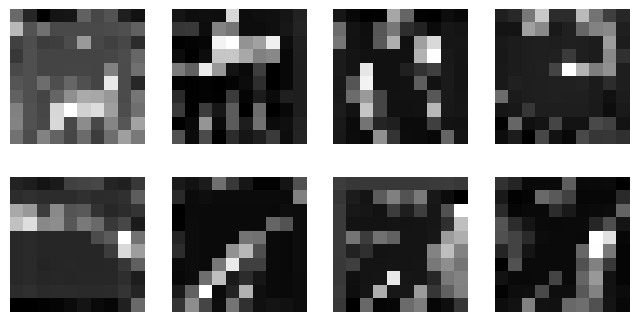

In [ ]:
# let's look at some of the network output.  It is a convolutional network, which
# means that every channel (i.e. every artificial neuron) is replicated on a
# 10x10 grid, looking at different parts of the image.
#
# the output array features has size nImages x nNeurons x 10 x 10. Let's look
# at some of them:

nIms, nChans, H, W = features.shape

plt.figure(figsize=(8,4))
feats_show = [0,1,3,4,7,8,10,11]
for i,f in enumerate(feats_show):
    plt.subplot(2,4,i+1)
    plt.imshow(features[ExampleImage,f], cmap='gray')
    plt.axis(False)

<ipython-input-7-abda88ca1510>:6: RuntimeWarning: Mean of empty slice
  mean_rate = np.nanmean(loaded_data['responses'],0)


(7250, 166)


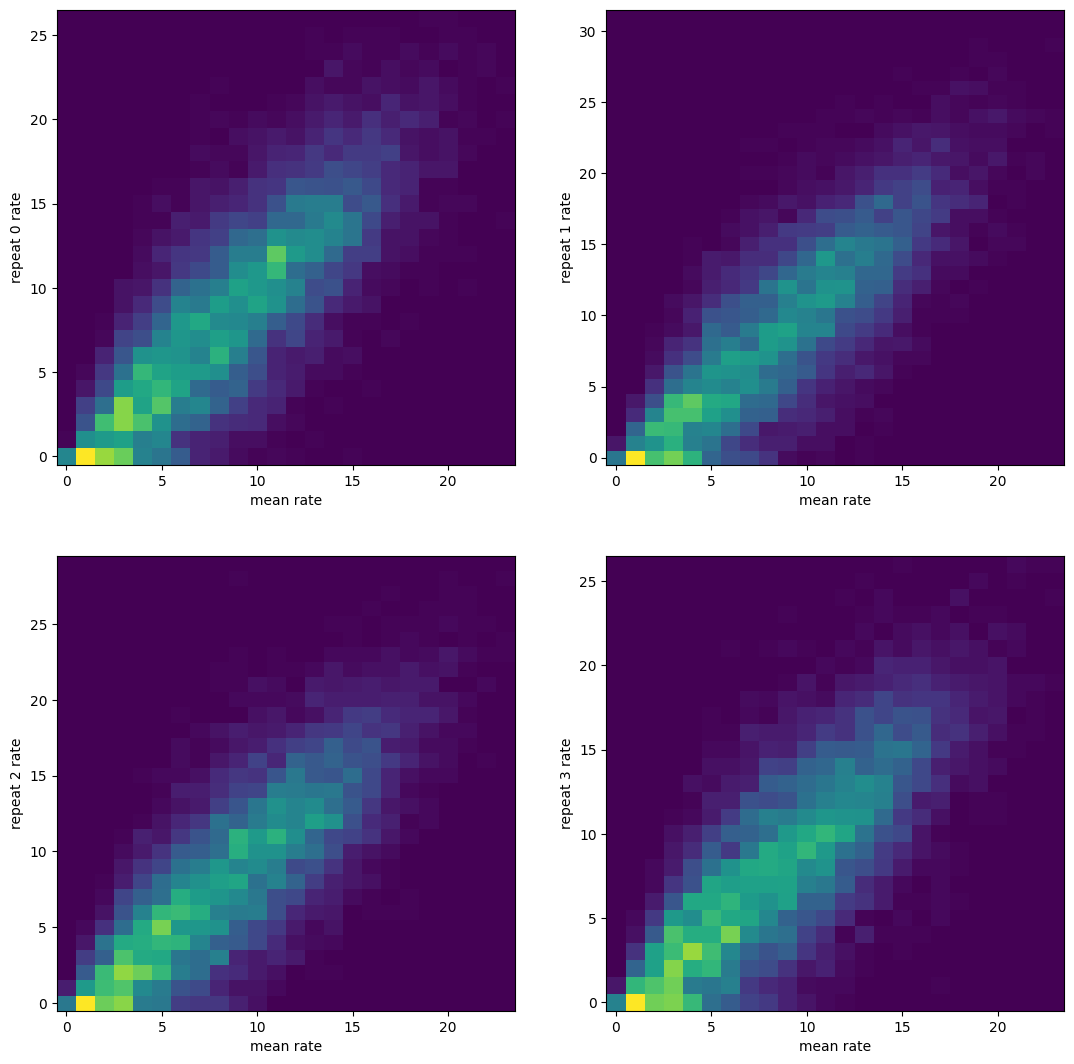

In [ ]:
# now let's look at some of the biological neurons

# first compute mean rate of all neurons. Use nanmean because not all neurons
# saw all images, and the data has nan where they did not.

mean_rate = np.nanmean(loaded_data['responses'],0)
print(mean_rate.shape)

# now for an example cell, look at how similar its response on each repeat is to
# the mean
exampleCell = 142

plt.figure(figsize=(13,13))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.hist2d(mean_rate[:,exampleCell], loaded_data['responses'][i,:,exampleCell],
             bins =[np.arange(-.5,mean_rate[:,exampleCell].max()+.5),
                    np.arange(-.5,loaded_data['responses'][i,:,exampleCell].max()+.5)
                    ])
  plt.xlabel('mean rate')
  plt.ylabel('repeat %d rate'%i)

EXERCISE 2: Look at this for other example cells. Try a scatter plot of mean vs each repeat.  What is the advantage of a density plot over a scatter plot in this case?

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


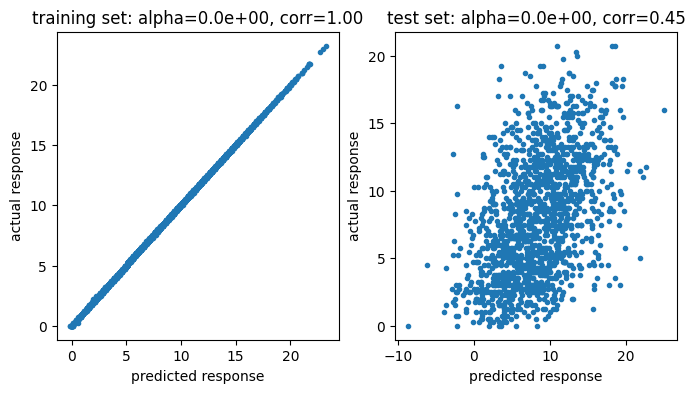

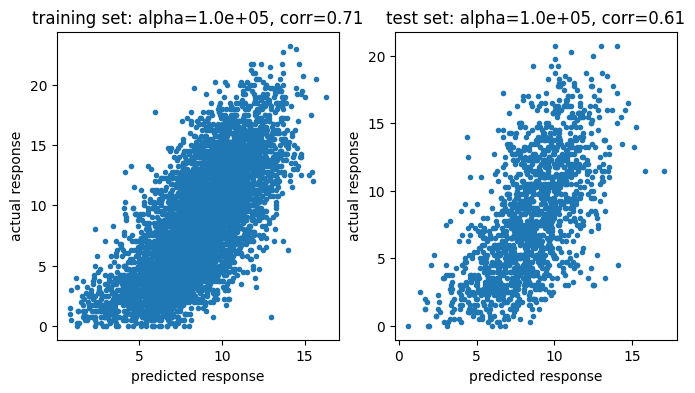

In [ ]:
# now we will predict our example cell by ridge regression
# WARNING this runs slowly on colab!

exampleCell = 142

# split images into training and test sets
test_ims = np.arange(0,nIms,5) # every 5th image is test set
train_ims = np.setdiff1d(np.arange(nIms), test_ims) # the rest are training

# make a flat array of prediction features nImages x nFeatures
feats_flat = features.reshape((nIms,-1))

# try with no alpha (i.e. ordinary linear regression) and with alpha=1e5
# (i.e. ridge regression)
for alpha in [0, 1e5]:

  # create the ridge regression object from scikit.learn and fit it to
  # predict our neuron from the ANN features
  reg = linear_model.Ridge(alpha=alpha)
  reg = reg.fit(feats_flat[train_ims,:],mean_rate[train_ims,exampleCell])

  # now plot training set responses
  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  train_pred = reg.predict(feats_flat[train_ims,:])
  plt.plot(train_pred, mean_rate[train_ims,exampleCell], '.')
  plt.ylabel('actual response')
  plt.xlabel('predicted response')
  cc = np.corrcoef(mean_rate[train_ims,exampleCell],train_pred)[0,1]
  plt.title('training set: alpha=%.1e, corr=%.2f'%(alpha,cc))

  # now plot test set responses
  plt.subplot(1,2,2)
  test_pred = reg.predict(feats_flat[test_ims,:])
  plt.plot(test_pred, mean_rate[test_ims,exampleCell], '.')
  plt.ylabel('actual response')
  plt.xlabel('predicted response')
  cc = np.corrcoef(mean_rate[test_ims,exampleCell],test_pred)[0,1]
  plt.title('test set: alpha=%.1e, corr=%.2f'%(alpha,cc))



EXERCISE 3: why is the fit so good on the training set for alpha=0?  Why is the fit on the test set worse for alpha=0 than for alpha=1e5?  What happens with values of alpha (e.g. 1, 10, 1e9)?

EXERCISE 4: Try again with different target cells.

HINT: to make it run faster, you might want to reduce the size of the training set by taking only a fraction of the usual training images

EXERCISE 5: find the ANN feature with the largest absolute magnitude regression weight (which is stored in `reg.coef_`) using `np.argmax` and `np.abs`.  Plot the activity of this feature against the activity of the target cell, for all test-set images.

It should look like below. Is the prediction from all neurons using ridge regression better? Why is there a vertical stripe and why is it not at x=0?

array([[ 1.        , -0.25234658],
       [-0.25234658,  1.        ]])

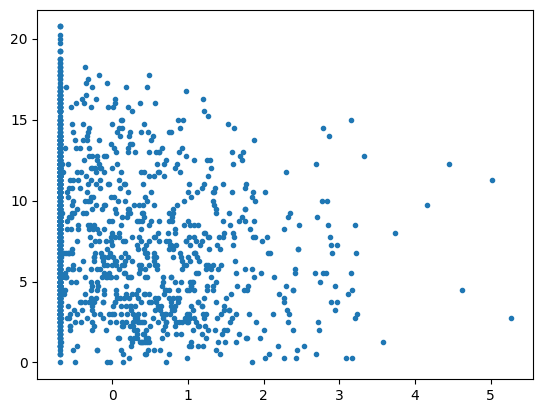

In [ ]:
# SHOULD LOOK LIKE BELOW

EXERCISE 6: Now try predicting the neuron directly from the pixels of the input image.  To do this, replace feats_flat with `images.detach().cpu().numpy()` - which takes the input images and turns them back to a numpy array from pytorch. You also have to reshape this array, the same way as for feats_flat.

Can you get a good prediction on the test set?  Try different values of alpha.

HINT: for speed you might again want to use only a subset of the training set


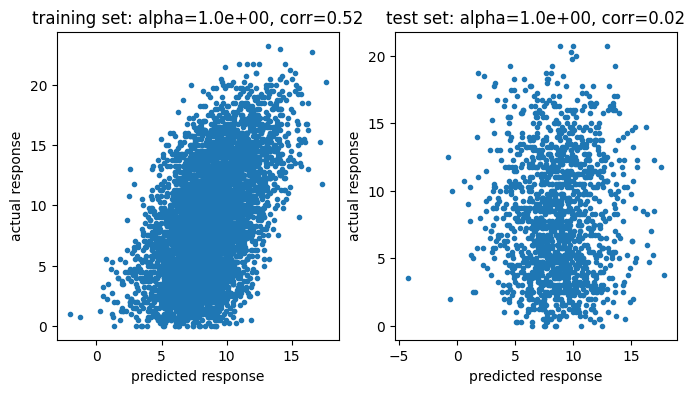

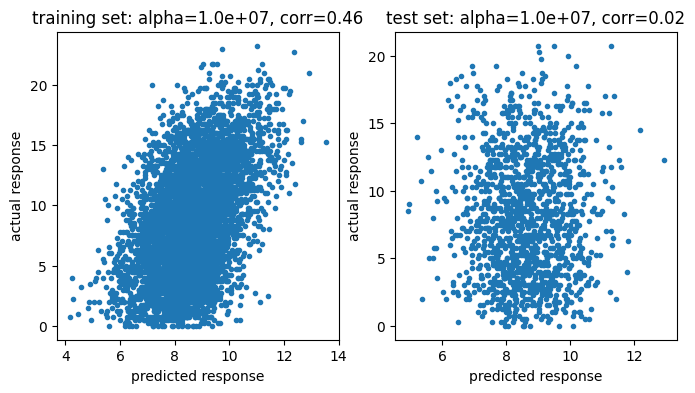

In [ ]:
# SHOULD LOOK LIKE BELOW: